In [ ]:
import pandas as pd
import numpy as np
import scipy.stats
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GroupKFold, RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, recall_score, accuracy_score, f1_score, roc_auc_score

Load Data from Disk

In [ ]:
train_df = pd.read_csv('data/training.csv')
test_df = pd.read_csv('data/testing.csv')
group_train = pd.read_csv('data/group_training.csv')
X_train = train_df.iloc[:, :-1]
y_train = train_df.iloc[:, -1]
X_test = test_df.iloc[:, :-1]
y_test = test_df.iloc[:, -1]
X_train.nunique()[X_train.nunique() < 2]

race                          5
gender                        3
age                          10
admission_type_id             8
discharge_disposition_id     26
admission_source_id          17
time_in_hospital             14
num_lab_procedures          117
num_procedures                7
num_medications              74
number_outpatient            37
number_emergency             33
number_inpatient             21
number_diagnoses             16
max_glu_serum                 4
A1Cresult                     4
metformin                     4
repaglinide                   4
nateglinide                   4
chlorpropamide                4
glimepiride                   4
acetohexamide                 1
glipizide                     4
glyburide                     4
tolbutamide                   2
pioglitazone                  4
rosiglitazone                 4
acarbose                      4
miglitol                      4
troglitazone                  2
tolazamide                    2
insulin 

In [ ]:
# Scaler
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Scorer
scorers={
    'recall': make_scorer(recall_score),
    'accuracy': make_scorer(accuracy_score),
    'macro_f1': make_scorer(f1_score, average='macro'),
    'weighted_f1': make_scorer(f1_score, average='weighted'),
    'roc_auc': make_scorer(roc_auc_score)
}

def compute_scores(y_test, y_pred):
    return {
        'recall':          recall_score(y_test, y_pred),
        'accuracy':        accuracy_score(y_test, y_pred),
        'macro_f1':        f1_score(y_test, y_pred, average='macro'),
        'weighted_f1':     f1_score(y_test, y_pred, average='weighted'),
        'macro_roc':       roc_auc_score(y_test, y_pred, average='macro'),
        'weighted_roc':    roc_auc_score(y_test, y_pred, average='weighted')
    }

In [ ]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py
def plot_roc_curve(fpr, tpr, roc_auc):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Parameter Search with GroupKFold and RandomizedSearchCV

### CV splitting strategy and Classifier

In [ ]:
# CV Split
gkf = GroupKFold(n_splits=5)

# Classifier
clf = MLPClassifier(verbose=True, random_state=42)

### Use smaller dataset to search quickly

In [ ]:
train_df = train_df.sample(n=len(train_df)//10, random_state=42)
group_train = group_train.loc[train_df.index]
X_train = train_df.iloc[:, :-1]
y_train = train_df.iloc[:, -1]

### Define parameter space

In [ ]:
param_dist = {
    'activation': ('tanh', 'relu'),
#     'early_stopping': (True,),
    'hidden_layer_sizes': ((64, 128, 64, 32), (64, 128, 64, 16)),
#     'solver': ('adam', ),
    'alpha': scipy.stats.reciprocal(0.01, 10),
    'max_iter': (1000, ) 
}

In [ ]:
rs = RandomizedSearchCV(clf, param_dist, n_iter=10, scoring=scorers, refit='recall', cv=gkf, n_jobs=-1, random_state=42)

In [ ]:
rs.fit(scaler.transform(X_train), y_train, groups=group_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   28.6s finished


RandomizedSearchCV(cv=GroupKFold(n_splits=5),
                   estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff7b2839e10>,
                                        'max_features': ['auto', 'sqrt'],
                                        'max_leaf_nodes': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff7b09fa410>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff7b09fa710>},
                   random_state=42, refit='macro_f1',
                   scoring={'accuracy': make_scorer(accuracy_score),
                            'macro_f1': make_scorer(f1_score, average=macro),
                            'roc_auc': make_scorer(roc_auc_score),
                            'weighted_

In [ ]:
print(rs.best_estimator_,
rs.score(X_train_scaled, y_train),
rs.score(X_test_scaled, y_test))

DecisionTreeClassifier(criterion='entropy', max_depth=60, max_features='sqrt',
                       max_leaf_nodes=16, min_samples_leaf=190,
                       random_state=42)


0.5906801470810901

              precision    recall  f1-score   support

           0       0.56      0.92      0.70      5490
           1       0.63      0.16      0.25      4645

    accuracy                           0.57     10135
   macro avg       0.60      0.54      0.47     10135
weighted avg       0.60      0.57      0.49     10135



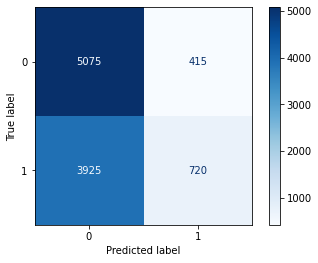

In [ ]:
y_pred = rs.predict(X_test_scaled)
print(classification_report(y_test, y_pred))
print(pd.DataFrame(compute_scores(y_test, y_pred), index=[0]))
plot_confusion_matrix(rs.best_estimator_, X_test_scaled, y_test, cmap='Blues')

# Training Baseline MLP

In [ ]:
mlp_base = MLPClassifier(random_state=42)
mlp_base.fit(X_train_scaled, y_train);

              precision    recall  f1-score   support

           0       0.65      0.70      0.67      5490
           1       0.61      0.55      0.58      4645

    accuracy                           0.63     10135
   macro avg       0.63      0.62      0.62     10135
weighted avg       0.63      0.63      0.63     10135

     recall  accuracy  macro_f1  weighted_f1  macro_roc  weighted_roc
0  0.549408  0.629896  0.623897     0.627858   0.623702      0.623702


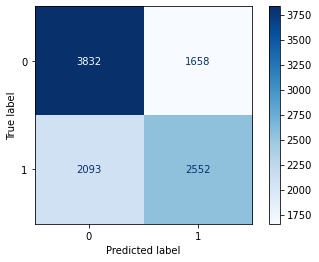

In [ ]:
y_pred = mlp_base.predict(X_test_scaled)
print(classification_report(y_test, y_pred))
print(pd.DataFrame(compute_scores(y_test, y_pred), index=[0]))
plot_confusion_matrix(mlp_base, X_test_scaled, y_test, cmap='Blues')

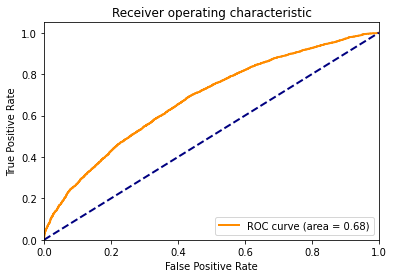

In [ ]:
# Compute ROC curve and ROC area for each class
y_score = mlp_base.predict_proba(X_test_scaled)
fpr, tpr, _ = roc_curve(y_test, y_score.T[1])
roc_auc = auc(fpr, tpr)
plot_roc_curve(fpr, tpr, roc_auc)


# Train Tuned MLP

In [ ]:
mlp_tuned = MLPClassifier(activation='tanh', alpha=0.9609812947036397,
                          hidden_layer_sizes=(64, 128, 64, 16), max_iter=1000,
                          random_state=42)
mlp_tuned.fit(X_train_scaled, y_train)

MLPClassifier(activation='tanh', alpha=0.9609812947036397,
              hidden_layer_sizes=(64, 128, 64, 16), max_iter=1000,
              random_state=42)

### Evaluate tuned model

              precision    recall  f1-score   support

           0       0.63      0.75      0.68      5490
           1       0.62      0.49      0.55      4645

    accuracy                           0.63     10135
   macro avg       0.63      0.62      0.62     10135
weighted avg       0.63      0.63      0.62     10135

     recall  accuracy  macro_f1  weighted_f1  macro_roc  weighted_roc
0  0.488913  0.627726  0.615321      0.62108   0.617043      0.617043


Text(0.5, 1.0, 'Confusion Matrix for Tuned MLP')

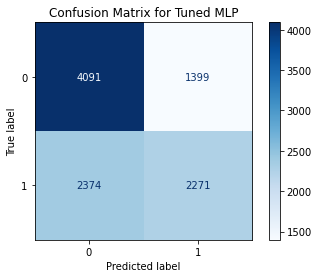

In [ ]:
y_pred = mlp_tuned.predict(X_test_scaled)
print(classification_report(y_test, y_pred))
print(pd.DataFrame(compute_scores(y_test, y_pred), index=[0]))
plot_confusion_matrix(mlp_tuned, X_test_scaled, y_test, cmap='Blues')
plt.title('Confusion Matrix for Tuned MLP')

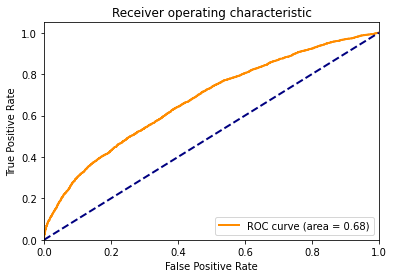

In [ ]:
# Compute ROC curve and ROC area for each class
y_score = mlp_tuned.predict_proba(X_test_scaled)
fpr, tpr, _ = roc_curve(y_test, y_score.T[1])
roc_auc = auc(fpr, tpr)
plot_roc_curve(fpr, tpr, roc_auc)
